In [ ]:
# ! pip uninstall surface_erasure_decoding
# ! pip3 install git+https://github.com/JiakaiW/surface_erasure_decoding

In [1]:
from surface_erasure_decoding import job_fixed_num_errors
import uuid
import itertools
import pickle
import zipfile
import os
import math
import matplotlib.pyplot as plt
import json
import datetime

In [2]:
from __future__ import annotations
from collections.abc import Callable,Sequence
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LogNorm
import numpy as np
from matplotlib.figure import Figure
from matplotlib.pyplot import Axes
from oscar import Landscape
from oscar import CustomExecutor
import matplotlib.ticker as ticker
from oscar import CSReconstructor

import sys
sys.path.append('..')
from surface_erasure_decoding import *
from IPython.display import clear_output

In [3]:
import statsmodels.stats.proportion as smp

def wilson_score_interval(x, n, confidence=0.95):
    """
    Compute the Wilson score confidence interval for a binomial proportion using statsmodels.
    
    Parameters:
    x : int
        Number of successes (yes outcomes).
    n : int
        Number of trials.
    confidence : float
        Confidence level for the interval (e.g., 0.95 for 95% confidence).
    
    Returns:
    (lower_bound, upper_bound) : tuple of floats
        Lower and upper bounds of the confidence interval.
    """
    lower_bound, upper_bound = smp.proportion_confint(x, n, alpha=1-confidence, method='wilson')
    return lower_bound, upper_bound

def generate_bool_array(tot, choose):
    array = np.zeros(tot, dtype=bool)
    indices = np.random.choice(tot, choose, replace=False)
    assert len(indices) == choose
    array[indices] = True
    return array

def get_weight(num_dice_e,num_dice_p,num_e_flipped,num_p_flipped,p_e,p_p):
    # Calculate binomial coefficients
    binom_e = math.comb(num_dice_e, num_e_flipped)
    binom_p = math.comb(num_dice_p, num_p_flipped)
    
    prob_e = (p_e ** num_e_flipped) * ((1 - p_e) ** (num_dice_e - num_e_flipped))
    prob_p = (p_p ** num_p_flipped) * ((1 - p_p) ** (num_dice_p - num_p_flipped))
    
    # Calculate the weight
    weight = binom_e * prob_e * binom_p * prob_p
    return weight

In [4]:
d = 5
p_e=0.01
p_p=0.001
after_cz_error_model = get_2q_error_model(p_e=p_e,
                                        p_p=p_p)
builder = easure_circ_builder(rounds = d,
                                distance= d,
                                after_cz_error_model=after_cz_error_model,
                                measurement_error=0
                                )
builder.generate_helper()
builder.gen_dummy_circuit()

non_trivial_gate_error_models = [attr_value for attr_name, attr_value in vars(builder).items() if isinstance(attr_value, GateErrorModel) and not  attr_value.trivial]
assert len(non_trivial_gate_error_models) == 1

tot_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].dummy_generator.num_qubit_called
tot_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].dummy_generator.num_qubit_called

num_qubit_per_dice_e = non_trivial_gate_error_models[0].name_to_mechanism['2q erasure'].deterministic_generator.num_qubit_per_dice
num_qubit_per_dice_p = non_trivial_gate_error_models[0].name_to_mechanism['2q depo'].deterministic_generator.num_qubit_per_dice

num_dice_e = int(tot_e/num_qubit_per_dice_e)
num_dice_p = int(tot_p/num_qubit_per_dice_p)

builder.gen_erasure_conversion_circuit()
erasure_circ_next_ancilla_qubit_index = builder.next_ancilla_qubit_index_in_list[0]
converter = builder.erasure_circuit.compile_m2d_converter()

# num dice is the total number of potential error locations for erasure (e) and 2-qubit depolarization (p)
num_dice_e, num_dice_p

(800, 400)

100%|██████████| 800/800 [00:11<00:00, 68.59it/s] 
/tmp/ipykernel_37324/1150076909.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
/tmp/ipykernel_37324/1150076909.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  contour_path = contour_set.collections[0].get_paths()[0]


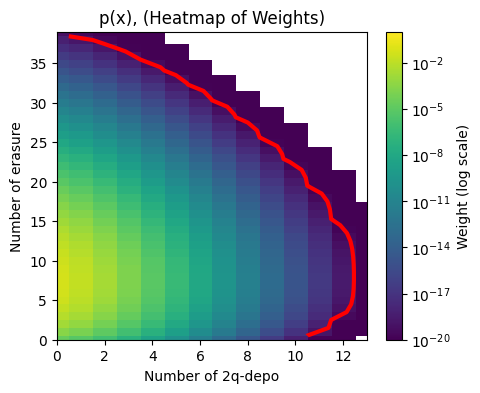

In [5]:
# Define the ranges for num_e_flipped and num_p_flipped
num_e_flipped_range = np.arange(0, num_dice_e,1)
num_p_flipped_range = np.arange(0, num_dice_p, 1)
 
# Initialize the weight matrix
weights = np.zeros((len(num_e_flipped_range), len(num_p_flipped_range)))

# Calculate weights for each combination of num_e_flipped and num_p_flipped
for i, num_e_flipped in enumerate(tqdm(num_e_flipped_range)):
    for j, num_p_flipped in enumerate(num_p_flipped_range):
        weights[i, j] = get_weight(num_dice_e, num_dice_p, num_e_flipped, num_p_flipped, p_e, p_p)



p_tolerance = 1e-13
flattened_weights = weights.flatten()
sorted_weights = np.sort(flattened_weights)#[::-1]
cumulative_sum = np.cumsum(sorted_weights)
cumulative_prob = cumulative_sum / cumulative_sum[-1]
cutoff_index = np.searchsorted(cumulative_prob, p_tolerance)
cutoff_value = sorted_weights[cutoff_index] if cutoff_index < len(sorted_weights) else sorted_weights[-1]

# Create the heatmap
plt.figure(figsize=(5, 4))
plt.imshow(weights, norm=LogNorm(vmin=1e-20,vmax = 1), origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(label='Weight (log scale)')
plt.xlabel('Number of p_flipped')
plt.ylabel('Number of e_flipped')
plt.title('Heatmap of Weights')


contour_set = plt.contour(weights, levels=[cutoff_value], colors='red', linewidths=3, norm=LogNorm(vmin=1e-20, vmax=1), origin='lower')
# Extract the path of the contour at level v
contour_path = contour_set.collections[0].get_paths()[0]

# Get the coordinates of the contour line
contour_coords = contour_path.vertices
x_coords = contour_coords[:, 0]
y_coords = contour_coords[:, 1]


x_min = np.floor(x_coords.min()).astype(int)
x_max = np.ceil(x_coords.max()).astype(int)
y_min = np.floor(y_coords.min()).astype(int)
y_max = np.ceil(y_coords.max()).astype(int)

# Set xlim and ylim using the min and max values
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xlabel('Number of 2q-depo')
plt.ylabel('Number of erasure')
plt.title('p(x), (Heatmap of Weights)')

plt.show()

In [6]:
reduced_num_p_arr = np.arange(x_min,x_max+1)
reduced_num_e_arr = np.arange(y_min,y_max+1)



shots = 1e4
counter  = 0
jobs_info = []
for i, num_p in enumerate(reduced_num_p_arr):
    for j, num_e in enumerate(reduced_num_e_arr):
        circuit_id=str(uuid.uuid4())
        job_id=str(uuid.uuid4())
        job = job_fixed_num_errors.Sample_decode_job(
                        job_id=job_id,
                        circuit_id=circuit_id,
                        d = d,
                        p_e=p_e,
                        p_p=p_p,
                        p_z_shift= 0.0,
                        p_m = 0.0,
                        shots=int(shots),
                        num_e_flipped = num_e,
                        num_p_flipped = num_p,
                        )
        with open(f"{counter}.pkl", "wb") as f:
            pickle.dump(job, f)
        counter += 1

        jobs_info.append({
            "job_id": job_id,
            "circuit_id": circuit_id,
            "d": d,
            "p_e": p_e,
            "p_z_shift": 0.0,
            "p_p": p_p,
            "p_m": 0.0,
            "shots": shots,
            "file": f"{counter}.pkl"
        })
print(f"num_jobs: {counter}")

# Save jobs information to a JSON file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"jobs_info_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json.dump(jobs_info, json_file, indent=4)


num_jobs: 560


In [7]:
def pack_pkl_files_to_zip(zip_filename="importance_sampling_input.zip"):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for filename in os.listdir('.'):
            name, ext = os.path.splitext(filename)
            if ext == '.pkl' and name.isdigit():
                zipf.write(filename)
                os.remove(filename)
                
pack_pkl_files_to_zip()

In [8]:
len(jobs_info)

560

In [8]:
import os
import json
import pandas as pd

json_list = []
directory = "importance_sampling_part1"
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as f:
            json_data = json.load(f)
        json_list.append(json_data)


df = pd.DataFrame(json_list)


In [12]:
# df.drop('job_id', axis=1, inplace=True)
agg_rules = {
    'num_shots': 'sum',
    'num_errors': 'sum',
    'num_e_flipped': 'first',
    'num_p_flipped': 'first',
}

df_grouped = df.groupby(['job_id', 'circuit_id']).agg(agg_rules).reset_index()
df_grouped['p_logi'] = df_grouped['num_errors'] / df_grouped['num_shots']

pd.set_option('display.max_rows', 15)
df_grouped.head(15)

,job_id,circuit_id,num_shots,num_errors,num_e_flipped,num_p_flipped,p_logi
0,00b3a67f-a515-43d8-a480-ccfd57013ccf,4fd1bd09-d5c1-4f09-a36b-e4557829a25e,10000,481,19,5,0.0481
1,00fbc6cc-e854-4ef1-a7ee-6f3bb09991a2,15d1ec92-df58-4daf-aaf7-6caa289d0204,10000,170,13,12,0.0170
2,011083b7-d398-48ae-bcf9-b3394b1e67c3,11f20d8a-6a82-421a-97b1-0c57ee84a74f,10000,227,14,5,0.0227
3,0165f204-9ecd-4ae5-99ca-f7c6badfc7a0,cc0065b6-7618-41df-8289-b6ff8bbd7109,10000,2192,37,10,0.2192
4,01ca70e3-423d-4b89-9bf1-7bb753b1bd44,742648cc-efbc-4aa3-b313-9c03e2911b24,10000,1247,28,8,0.1247
5,01e2344f-f7f0-461a-8161-60998b12d46d,ba3fa773-7462-4811-96b5-25fe6bc3cb69,10000,165,13,3,0.0165
6,025e9251-f6b5-4d17-8686-2f38ced25028,1c61ce18-8ca9-42e2-99a4-007b0d38361d,10000,0,0,9,0.0000
7,0289f36e-3ca2-4886-b266-29aec8af8a42,81729971-21c9-4770-b530-12d8d11405dc,10000,23,7,13,0.0023
8,0294643d-2443-43d8-8fe9-701b72320a76,370ea6ce-dff7-4378-9337-b76b6d83c67a,10000,82,10,4,0.0082
9,03125e5c-1968-47c5-b836-cf5e0162807e,16f1458d-4035-4023-8419-0b8582176c2c,10000,25,7,1,0.0025


In [13]:
num_shots_arr = np.zeros(shape=(len(reduced_num_p_arr),len(reduced_num_e_arr)))
num_errors_arr = np.zeros(shape=(len(reduced_num_p_arr),len(reduced_num_e_arr)))

for i,num_p in enumerate(reduced_num_p_arr):
    for j, num_e in enumerate(reduced_num_e_arr):
        num_shots_arr[i,j] =   df_grouped.loc[(df_grouped['num_e_flipped'] == num_e) &
                                    (df_grouped['num_p_flipped'] == num_p) , 'num_shots'].iloc[0]
        num_errors_arr[i,j] =   df_grouped.loc[(df_grouped['num_e_flipped'] == num_e) &
                                    (df_grouped['num_p_flipped'] == num_p) , 'num_errors'].iloc[0]

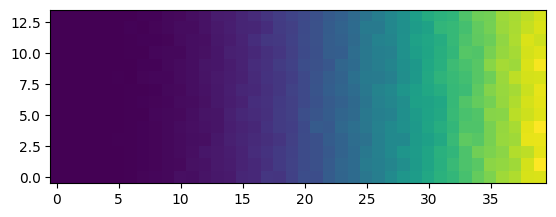

In [15]:
plt.imshow(num_errors_arr,origin='lower')